Authors: Zoe Christ, Antonia Dieterich, Sandra Hils; Dataset: https://www.kaggle.com/ishadss/eucalyptus?select=dataset_194_eucalyptus.csv


Import all necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#import classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC

#data preparation
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

#evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Load data from csv file

In [3]:
data=pd.read_csv('eucalyptus.csv')

In [4]:
#show first five rows of dataset
data.head()

,Abbrev,Rep,Locality,Map_Ref,Latitude,Altitude,Rainfall,Frosts,Year,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,Crown_Fm,Brnch_Fm,Utility
0,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,co,1520,18.45,9.96,40,4,3,3.5,4,3.5,good
1,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,fr,1487,13.15,9.65,90,4.5,4,3.5,3.5,3,best
2,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,ma,1362,10.32,6.5,50,2.3,2.5,3,3.5,3,low
3,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,nd,1596,14.8,9.48,70,3.7,3,3.3,4,3.5,good
4,Cra,1,Central_Hawkes_Bay,N135_382/137,39__38,100,850,-2,1980,ni,2088,14.5,10.78,90,4,2.7,3.3,3,3,good


Data understanding

In [5]:
#show number of rows and columns
data.shape

(736, 20)

In [6]:
#find missing values
data.isna().sum()

Abbrev      0
Rep         0
Locality    0
Map_Ref     0
Latitude    0
Altitude    0
Rainfall    0
Frosts      0
Year        0
Sp          0
PMCno       0
DBH         0
Ht          0
Surv        0
Vig         0
Ins_res     0
Stem_Fm     0
Crown_Fm    0
Brnch_Fm    0
Utility     0
dtype: int64

In [7]:
#function: number of unknown values per column
def showUnknown(x):
    print(x, " :", data[x].value_counts()['?'])

In [8]:
#list of columns with unknown values
questionList = ['PMCno', 'DBH', 'Ht', 'Surv', 'Vig', 'Ins_res', 'Stem_Fm', 'Crown_Fm', 'Brnch_Fm']

#execute function showUnknown
for i in questionList:
    showUnknown(i)

PMCno  : 7
DBH  : 1
Ht  : 1
Surv  : 94
Vig  : 69
Ins_res  : 69
Stem_Fm  : 69
Crown_Fm  : 69
Brnch_Fm  : 69


In [9]:
#List of column names
feature_names=list(data.columns)
print(feature_names)

['Abbrev', 'Rep', 'Locality', 'Map_Ref', 'Latitude', 'Altitude', 'Rainfall', 'Frosts', 'Year', 'Sp', 'PMCno', 'DBH', 'Ht', 'Surv', 'Vig', 'Ins_res', 'Stem_Fm', 'Crown_Fm', 'Brnch_Fm', 'Utility']


In [10]:
#function: delete data with '?'
def dropValues(s):
    data.drop(data.loc[data[s]=='?'].index, inplace=True)

#execute function dropValues
for i in feature_names:
    dropValues(i)

data.shape

(641, 20)

In [11]:
#replace all "ma" values in column Sp (Species) with mn, because the data was recorded incorrectly
data['Sp'] = data['Sp'].replace(['ma'], 'mn')

In [12]:
#Unique values target classes
print(data['Utility'].unique())

['good' 'best' 'low' 'average' 'none']


In [13]:
#distribution of the values per class
freq = data['Utility'].value_counts()
print(freq)

good       203
average    128
none       110
low        102
best        98
Name: Utility, dtype: int64


<AxesSubplot:title={'center':'Utility'}>

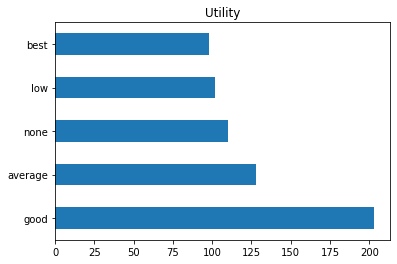

In [14]:
#graphic of the distribution
data["Utility"].value_counts().plot.barh(title='Utility')

In [15]:
#encode the values of target classes manually, combining values of none and low
data['Utility']= data['Utility'].replace(['none'], 0)
data['Utility']= data['Utility'].replace(['low'], 0)
data['Utility']= data['Utility'].replace(['average'], 1)
data['Utility']= data['Utility'].replace(['good'], 2)
data['Utility']= data['Utility'].replace(['best'], 3)

In [16]:
#new distribution of target classes
freq2 = data['Utility'].value_counts()
print(freq2)

0    212
2    203
1    128
3     98
Name: Utility, dtype: int64


In [17]:
#add new column with value bulk = DBH * DBH * Ht
data['DBH']=pd.to_numeric(data['DBH'])
data['Ht']=pd.to_numeric(data['Ht'])
data['Bulk'] = data['DBH'] * data['DBH'] * data['Ht']

In [18]:
#split dataset in numeric, non numeric and target
num_cols=['Rep','Altitude', 'Rainfall', 'Frosts', 'Year', 'Bulk']
nonnum_cols=['Locality', 'Map_Ref', 'Sp', 'PMCno', 'DBH', 'Ht', 'Surv', 'Vig', 'Ins_res', 'Stem_Fm', 'Crown_Fm', 'Brnch_Fm', 'Latitude', 'Abbrev']
target = 'Utility'

In [19]:
#function: label encoder
def label_encoder(d):
    le = preprocessing.LabelEncoder()
    return le.fit_transform(d)

#create separate dataframes and encode nonumeric columns
df_label_encoded = data[nonnum_cols].apply(label_encoder)
df_num = data[num_cols]
df_target = data[target]


In [20]:
#merge the dataframes
data = pd.concat([df_label_encoded, df_num, df_target], axis=1)
data.head()

,Locality,Map_Ref,Sp,PMCno,DBH,Ht,Surv,Vig,Ins_res,Stem_Fm,...,Brnch_Fm,Latitude,Abbrev,Rep,Altitude,Rainfall,Frosts,Year,Bulk,Utility
0,0,0,4,17,379,288,23,24,16,15,...,21,0,0,1,100,850,-2,1980,3390.408900,2
1,0,0,8,16,263,272,45,28,26,15,...,16,0,0,1,100,850,-2,1980,1668.702125,3
2,0,0,11,14,200,151,30,9,12,10,...,16,0,0,1,100,850,-2,1980,692.265600,0
3,0,0,13,25,297,266,38,21,16,13,...,21,0,0,1,100,850,-2,1980,2076.499200,2
4,0,0,14,33,290,316,45,24,14,13,...,16,0,0,1,100,850,-2,1980,2266.495000,2


show columns with outliers

<AxesSubplot:xlabel='Altitude'>

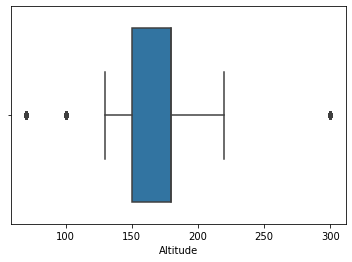

In [21]:
#Altitude
sns.boxplot(x=data['Altitude'])

<AxesSubplot:title={'center':'Altitude'}>

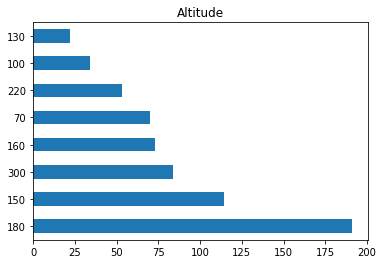

In [22]:
#Distribution of Altitude to visualize outliers
data["Altitude"].value_counts().plot.barh(title='Altitude')

<AxesSubplot:xlabel='Rep'>

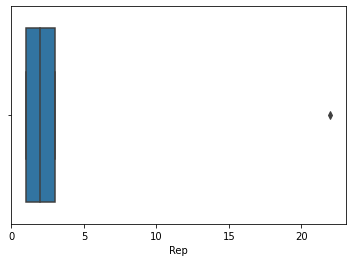

In [23]:
#Rep
sns.boxplot(x=data['Rep'])

<AxesSubplot:title={'center':'Rep'}>

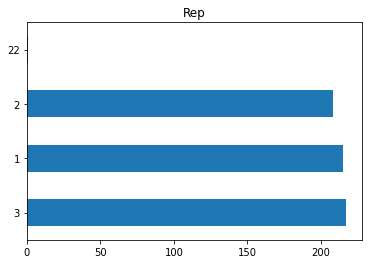

In [24]:
#Distribution of Rep to visualize outliers
data["Rep"].value_counts().plot.barh(title='Rep')

<AxesSubplot:xlabel='Locality'>

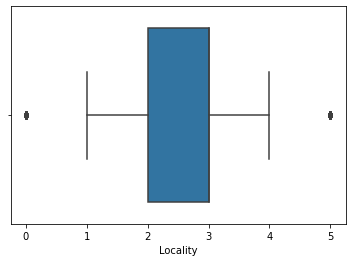

In [25]:
#Locality
sns.boxplot(x=data['Locality'])

<AxesSubplot:title={'center':'Locality'}>

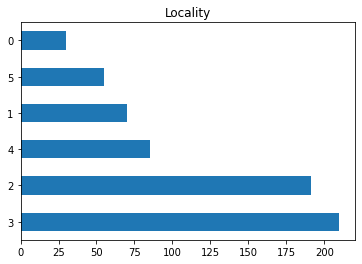

In [26]:
#Distribution of Locality to visualize outliers
data["Locality"].value_counts().plot.barh(title='Locality')

<AxesSubplot:>

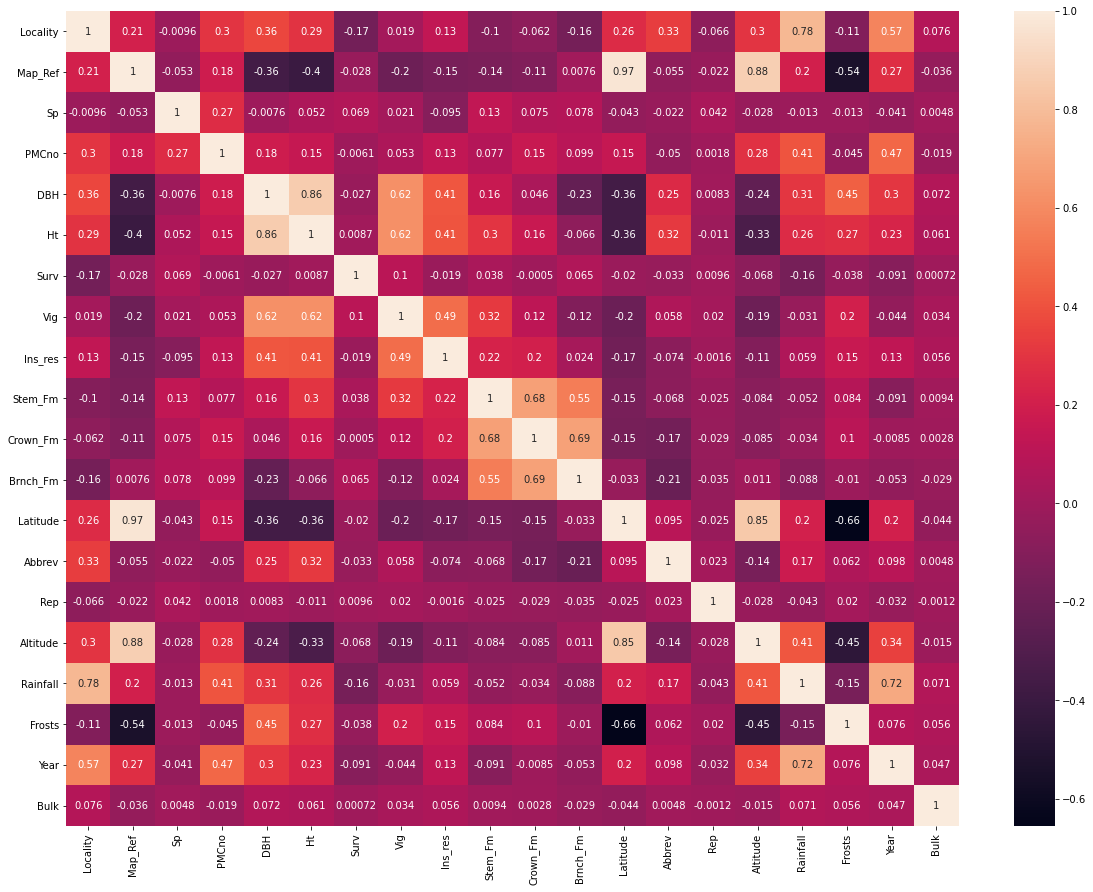

In [27]:
#create heatmap to show correlations
heatmap_data = data.drop(['Utility'], axis=1)
plt.subplots(figsize=(20,15))
sns.heatmap(heatmap_data.corr(), annot = True)

In [28]:
#delete column 'Latitude' due to high correlation with "Map_Ref"
#Dropping 'Latitude' achieves higher accuracy than dropping 'Map_Ref' 
data = data.drop(['Latitude'], axis=1)

In [29]:
# define y
y = data.iloc[:,-1]
# define X
X = data.iloc[:,:-1]

In [30]:
#splitting data in test and training data
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)

Modeling

In [31]:
# save the models und names in a list
models = []
models.append(('LR', LogisticRegression(random_state=2, solver='liblinear', multi_class='ovr')))
models.append(('RFC', RandomForestClassifier(random_state=2)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DTC', DecisionTreeClassifier(random_state=2, criterion = 'entropy')))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=2, gamma='auto')))
models.append(('XGB', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=2)))

# evaluate each model with k-fold Cross-Validation
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=3, shuffle=True)
	cv_results = cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
	results.append(cv_results)
	names.append(name)
	#print mean and standard deviation
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
	

LR: 0.352620 (0.118124)
RFC: 0.705096 (0.044731)
KNN: 0.477380 (0.032858)
DTC: 0.625577 (0.041376)
NB: 0.360433 (0.053753)
SVM: 0.333870 (0.008197)
XGB: 0.705096 (0.040732)


Continuing with the classifiers "decision tree with gradient boosting (XGBoost)" and "random forest" since they initially achieved the highest accuracies

Hyperparameter tuning for xgboost

In [32]:
#tuning max_depth
#max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
d = [2,4,5, 6, 8,10,]
for i in d:
    xgbClass = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=2, max_depth = i)
    xgbClass.fit(X_train, y_train)
    pred3 = xgbClass.fit(X_train, y_train).predict(X_test)
    #print accuracy for each value d for max_depth
    print("XGB accuracy - test data: ", i, " :",accuracy_score(y_test, pred3))

XGB accuracy - test data:  2  : 0.6666666666666666
XGB accuracy - test data:  4  : 0.689922480620155
XGB accuracy - test data:  5  : 0.7131782945736435
XGB accuracy - test data:  6  : 0.7131782945736435
XGB accuracy - test data:  8  : 0.6744186046511628
XGB accuracy - test data:  10  : 0.6744186046511628


result of hyperparameter tuning: max_depth = 5 is optimal

hyperparameter tuning with randomized search cross validation

In [33]:
# creating random_grid containing lists of different values for all parameters
random_grid = {
#step size shrinkage used in update to prevent overfitting
"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
#Subsample ratio of the training instances.
"subsample" : [ 0.3, 0.4, 0.5 , 0.7 ],
#Minimum sum of instance weight (hessian) needed in a child
 "min_child_weight" : [ 1, 3, 5, 7 ],
 #minimum loss reduction required to make a further partition on a leaf node of the tree
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 #subsample ratio of columns when constructing each tree
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 #number of trees in xgboost ensemble
 "n_estimators" : [ 50, 100, 200, 300, 400, 500 ]}
print(random_grid)

{'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], 'subsample': [0.3, 0.4, 0.5, 0.7], 'min_child_weight': [1, 3, 5, 7], 'gamma': [0.0, 0.1, 0.2, 0.3, 0.4], 'colsample_bytree': [0.3, 0.4, 0.5, 0.7], 'n_estimators': [50, 100, 200, 300, 400, 500]}


In [34]:
# create the base model of the xgb classifier for tuning
xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=2, max_depth = 5)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=2, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)
#show best parameters
xgb_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'subsample': 0.3,
 'n_estimators': 100,
 'min_child_weight': 1,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.5}

In [35]:
#XGB with best parameters (results from random search)
xgbClass = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, num_class=3, random_state=2, max_depth=5, subsample=0.3, n_estimators=100, min_child_weight=1, learning_rate=0.05, gamma=0.2, colsample_bytree=0.5)
#Accuracy of the data with new parameters
xgbClass.fit(X_train, y_train)
pred = xgbClass.fit(X_train, y_train).predict(X_test)
print("XGB accuracy - test data : ",accuracy_score(y_test, pred))

XGB accuracy - test data :  0.6511627906976745


Evaluation of xgb classifier model with best parameters

In [36]:
#best XGBoost Model
xgbClass = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, num_class=3, random_state=2, max_depth=5)
#Accuracy test data
xgbClass.fit(X_train, y_train)
pred = xgbClass.fit(X_train, y_train).predict(X_test)
print("XGB accuracy - test data : ",accuracy_score(y_test, pred))

XGB accuracy - test data :  0.7131782945736435


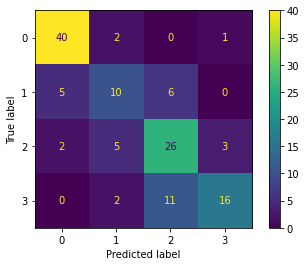

In [37]:
#create confusion matrix
#most observations were classified correctly or as their class +/-1
plot_confusion_matrix(xgbClass, X_test, y_test)

In [38]:
#show classification report
label_names = ['low', 'average', 'good', 'best']
print(classification_report(y_test,pred,target_names=label_names))

              precision    recall  f1-score   support

         low       0.85      0.93      0.89        43
     average       0.53      0.48      0.50        21
        good       0.60      0.72      0.66        36
        best       0.80      0.55      0.65        29

    accuracy                           0.71       129
   macro avg       0.70      0.67      0.68       129
weighted avg       0.72      0.71      0.71       129



Hyperparameter tuning for RandomForestClassifier using RandomSearch and cross validation

In [39]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 400, num = 40)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum depth of the tree
max_depth = [int(x) for x in np.linspace(2, 100, num = 25)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8]
#function to measure the quality of a split
criterion = ['gini', 'entropy']
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 51, 55, 59, 63, 67, 71, 75, 79, 83, 87, 91, 95, 100, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}


In [40]:
# create the base model of the RandomForestClassifier for tuning
rfc = RandomForestClassifier(random_state=2)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=2, n_jobs = -1)
# Fit the random search model
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 6, 10, 14, 18, 22, 26,
                                                      30, 34, 38, 42, 46, 51,
                                                      55, 59, 63, 67, 71, 75,
                                                      79, 83, 87, 91, 95, 100,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9,

In [41]:
#show best parameters
rfc_random.best_params_

{'n_estimators': 360,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 14,
 'criterion': 'entropy'}

Evaluation of RandomforestClassifier with best parameters

In [42]:
#new RandomforestClassifier with best parameters
rfc2 = RandomForestClassifier(n_estimators=360, min_samples_split=5, min_samples_leaf=2, max_features='auto', max_depth=14, criterion='entropy', random_state=2)
#train the algorithm on training data and predict using the testing data
pred = rfc2.fit(X_train, y_train).predict(X_test)
#print the accuracy score of the model
print("Random Forest accuracy: ",accuracy_score(y_test, pred))

Random Forest accuracy:  0.6589147286821705


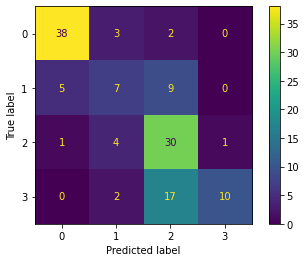

In [43]:
#create the confusion matrix
#most observations were classified correctly or as their class +/-1
plot_confusion_matrix(rfc2, X_test, y_test) 

In [44]:
#show the classification report
label_names = ['low', 'average', 'good', 'best']
print(classification_report(y_test,pred,target_names=label_names))

              precision    recall  f1-score   support

         low       0.86      0.88      0.87        43
     average       0.44      0.33      0.38        21
        good       0.52      0.83      0.64        36
        best       0.91      0.34      0.50        29

    accuracy                           0.66       129
   macro avg       0.68      0.60      0.60       129
weighted avg       0.71      0.66      0.64       129

